# Bharath Gunasekaran
HW 6 CMPE 258

# Defining Tensor Class

In [23]:
import numpy as np

class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 parents=None,
                 parent_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id
        
        self.parents = parents
        self.parent_op = parent_op
        self.children = {}
        
        if(parents is not None):
            for c in parents:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            assert grad.autograd == False
            
            if(self.parents is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.parent_op == "add"):
                    self.parents[0].backward(self.grad, self)
                    self.parents[1].backward(self.grad, self)
                    
                if(self.parent_op == "sub"):
                    self.parents[0].backward(Tensor(self.grad.data), self)
                    self.parents[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.parent_op == "mul"):
                    new = self.grad * self.parents[1]
                    self.parents[0].backward(new , self)
                    new = self.grad * self.parents[0]
                    self.parents[1].backward(new, self)                    
                    
                if(self.parent_op == "mm"):
                    c0 = self.parents[0]
                    c1 = self.parents[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.parent_op == "transpose"):
                    self.parents[0].backward(self.grad.transpose())

                if("sum" in self.parent_op):
                    dim = int(self.parent_op.split("_")[1])
                    self.parents[0].backward(self.grad.expand(dim,
                                                               self.parents[0].data.shape[dim]))

                if("expand" in self.parent_op):
                    dim = int(self.parent_op.split("_")[1])
                    self.parents[0].backward(self.grad.sum(dim))
                    
                if(self.parent_op == "neg"):
                    self.parents[0].backward(self.grad.__neg__())
                    
                if(self.parent_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.parents[0].backward(self.grad * (self * (ones - self)))
                
                if(self.parent_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.parents[0].backward(self.grad * (ones - (self * self)))
                
                if(self.parent_op == "relu"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.parents[0].backward(self.grad * (self.data > 0))

                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          parents=[self,other],
                          parent_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          parents=[self,other],
                          parent_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          parents=[self,other],
                          parent_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          parents=[self,other],
                          parent_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          parents=[self],
                          parent_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          parents=[self],
                          parent_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          parents=[self],
                          parent_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          parents=[self,x],
                          parent_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          parents=[self],
                          parent_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          parents=[self],
                          parent_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def relu(self):
        if(self.autograd):
            return Tensor(np.maximum(np.zeros_like(self.data),self.data),
                          autograd=True,
                          parents=[self],
                          parent_op="relu")
        return Tensor(np.maximum(np.zeros_like(self.data),self.data))
        
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  
    


# Unit Tests


In [31]:
  # Testing Add
  x = Tensor([1, 2, 3, 4, 5], autograd=True)
  y = Tensor([1, 1, 1, 1, 1], autograd=True)
  z = x+y
  z.backward(Tensor(np.array([1, 1, 1, 1, 1])))
  np.testing.assert_array_equal(x.grad.data, [1, 1, 1, 1, 1])
  np.testing.assert_array_equal(y.grad.data, [1, 1, 1, 1, 1])


In [32]:
  # Testing Sub
  x = Tensor([1, 2, 3, 4, 5], autograd=True)
  y = Tensor([1, 1, 1, 1, 1], autograd=True)
  z = x-y
  z.backward(Tensor(np.array([1, 1, 1, 1, 1])))
  np.testing.assert_array_equal(x.grad.data, [1, 1, 1, 1, 1])
  np.testing.assert_array_equal(y.grad.data, [-1, -1, -1, -1, -1])


In [16]:
class SGD(object):
    
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha
    
    def zero(self):
        for p in self.parameters:
            p.grad.data *= 0
        
    def step(self, zero=True):
        
        for p in self.parameters:
            
            p.data -= p.grad.data * self.alpha
            
            if(zero):
                p.grad.data *= 0

In [17]:
class Layer(object):
    
    def __init__(self):
        self.parameters = list()
        
    def get_parameters(self):
        return self.parameters


class Linear(Layer):

    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        W = np.random.randn(n_inputs, n_outputs) * np.sqrt(2.0/(n_inputs))
        self.weight = Tensor(W, autograd=True)
        self.bias = Tensor(np.zeros(n_outputs), autograd=True)
        
        self.parameters.append(self.weight)
        self.parameters.append(self.bias)

    def forward(self, input):
        return input.mm(self.weight)+self.bias.expand(0,len(input.data))

In [18]:
class Sequential(Layer):
    
    def __init__(self, layers=list()):
        super().__init__()
        
        self.layers = layers
    
    def add(self, layer):
        self.layers.append(layer)
        
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input
    
    def get_parameters(self):
        params = list()
        for l in self.layers:
            params += l.get_parameters()
        return params

In [19]:
class MSELoss(Layer):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, pred, target):
        return ((pred - target)*(pred - target)).sum(0)

In [20]:
class Tanh(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.tanh()
    
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.sigmoid()

In [21]:
class Relu(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.relu()

In [25]:
import numpy
np.random.seed(0)

data = Tensor(np.array([[0,0],[0,1],[1,0],[1,1]]), autograd=True)
target = Tensor(np.array([[0],[1],[0],[1]]), autograd=True)

model = Sequential([Linear(2,3), Tanh(), Linear(3,1), Sigmoid()])
criterion = MSELoss()

optim = SGD(parameters=model.get_parameters(), alpha=1)

for i in range(10):
    
    # Predict
    pred = model.forward(data)
    
    # Compare
    loss = criterion.forward(pred, target)
    
    # Learn
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    print(loss)

[1.06372865]
[0.75148144]
[0.57384259]
[0.39574294]
[0.2482279]
[0.15515294]
[0.10423398]
[0.07571169]
[0.05837623]
[0.04700013]


In [24]:
import numpy
np.random.seed(0)

data = Tensor(np.array([[0,0],[0,1],[1,0],[1,1]]), autograd=True)
target = Tensor(np.array([[0],[1],[0],[1]]), autograd=True)

model = Sequential([Linear(2,3), Relu(), Linear(3,1), Sigmoid()])
criterion = MSELoss()

optim = SGD(parameters=model.get_parameters(), alpha=1)

for i in range(10):
    
    # Predict
    pred = model.forward(data)
    
    # Compare
    loss = criterion.forward(pred, target)
    
    # Learn
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    print(loss)

[1.08079127]
[0.68681444]
[0.47124889]
[0.33092758]
[0.2373891]
[0.17621206]
[0.1351892]
[0.10290588]
[0.08081334]
[0.06520201]


In [26]:
np.random.seed(0)

data = Tensor(np.array([[0,0],[0,1],[1,0],[1,1]]), autograd=True)
target = Tensor(np.array([[0],[1],[0],[1]]), autograd=True)

model = Sequential([Linear(2,3), Linear(3,1)])
criterion = MSELoss()

optim = SGD(parameters=model.get_parameters(), alpha=0.05)

for i in range(10):
    
    # Predict
    pred = model.forward(data)
    
    # Compare
    loss = criterion.forward(pred, target)
    
    # Learn
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    print(loss)

[2.33428272]
[0.06743796]
[0.0521849]
[0.04079507]
[0.03184365]
[0.02479336]
[0.01925443]
[0.01491699]
[0.01153118]
[0.00889602]


# MNIST Classification

In [27]:
from keras.datasets import mnist
import numpy as np

# Load MNIST dataset from keras
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Number of samples
n = 1000
random_index = np.random.randint(n, size=n) # Randomly select training data
images, labels = (X_train[random_index].reshape(len(X_train[random_index]),28*28)/255, Y_train[random_index])

# Convert train label into one-hot encoding
train_labels = np.zeros((len(labels),10))
for i,l in enumerate(labels):
    train_labels[i][l] = 1

# Flatten the testing data 
test_images = X_test.reshape(len(X_test),28*28)/255

test_labels = np.zeros((len(Y_test),10)) # one-hot encode test labels
for i,l in enumerate(Y_test):
    test_labels[i][l] = 1

print(f'Train Data: {images.shape}, Train Label: {train_labels.shape}, Test Data: {test_images.shape}, Test Label: {test_labels.shape}')

Train Data: (1000, 784), Train Label: (1000, 10), Test Data: (10000, 784), Test Label: (10000, 10)


In [28]:
data = Tensor(images, autograd=True)
target = Tensor(train_labels, autograd=True)

model = Sequential([Linear(784,400), Relu() ,Linear(400,200), Relu(),Linear(200,80), Tanh(), Linear(80,10), Sigmoid()])
criterion = MSELoss()

optim = SGD(parameters=model.get_parameters(), alpha=0.001)
batch_size = 256
for epoch in range(300):
    pred = model.forward(data)
    
    # Compare
    loss = criterion.forward(pred, target)
    
    # Learn
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    train_correct = (np.argmax(target.data,axis=1) == np.argmax(pred.data,axis=1)).mean()
    if(epoch % 10 == 0):
      print("Epoch", epoch,"Train Accuracy:",train_correct,"Train Loss:", (loss.sum(0).data)/len(data.data))
    # print(loss)

Epoch 0 Train Accuracy: 0.089 Train Loss: 2.6508664796113686
Epoch 10 Train Accuracy: 0.113 Train Loss: 0.9215548865433505
Epoch 20 Train Accuracy: 0.158 Train Loss: 0.9147453516935969
Epoch 30 Train Accuracy: 0.151 Train Loss: 0.9477065791567634
Epoch 40 Train Accuracy: 0.108 Train Loss: 0.9422463331617448
Epoch 50 Train Accuracy: 0.09 Train Loss: 0.9215076370718391
Epoch 60 Train Accuracy: 0.143 Train Loss: 0.9478610560843823
Epoch 70 Train Accuracy: 0.23 Train Loss: 0.9312369716566865
Epoch 80 Train Accuracy: 0.093 Train Loss: 0.987041452612764
Epoch 90 Train Accuracy: 0.089 Train Loss: 0.974012306930005
Epoch 100 Train Accuracy: 0.093 Train Loss: 0.9480107867353113
Epoch 110 Train Accuracy: 0.161 Train Loss: 0.9559859954340366
Epoch 120 Train Accuracy: 0.089 Train Loss: 0.9784427584835181
Epoch 130 Train Accuracy: 0.108 Train Loss: 0.9851452460419013
Epoch 140 Train Accuracy: 0.108 Train Loss: 0.9688444362390879
Epoch 150 Train Accuracy: 0.09 Train Loss: 0.9668304205168194
Epoch 16

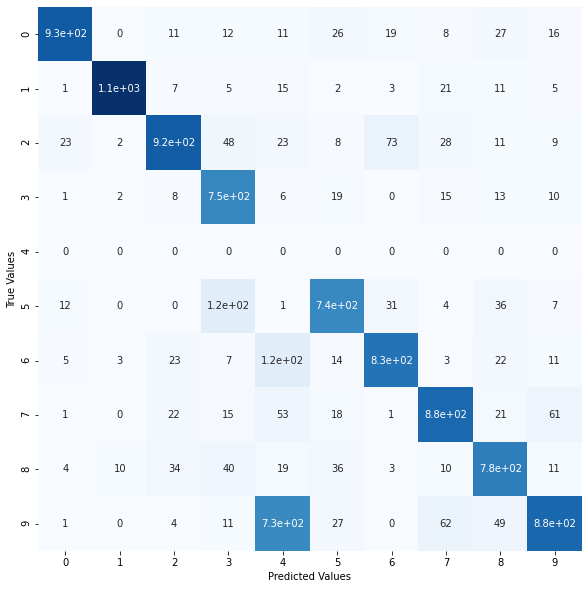

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

test_data = Tensor(test_images, autograd=True)
test_target = Tensor(test_labels, autograd=True)
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.forward(test_data) 
Y_pred = np.argmax(y_pred.data, 1) # Decode Predicted labels
Y_test = np.argmax(test_target.data, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

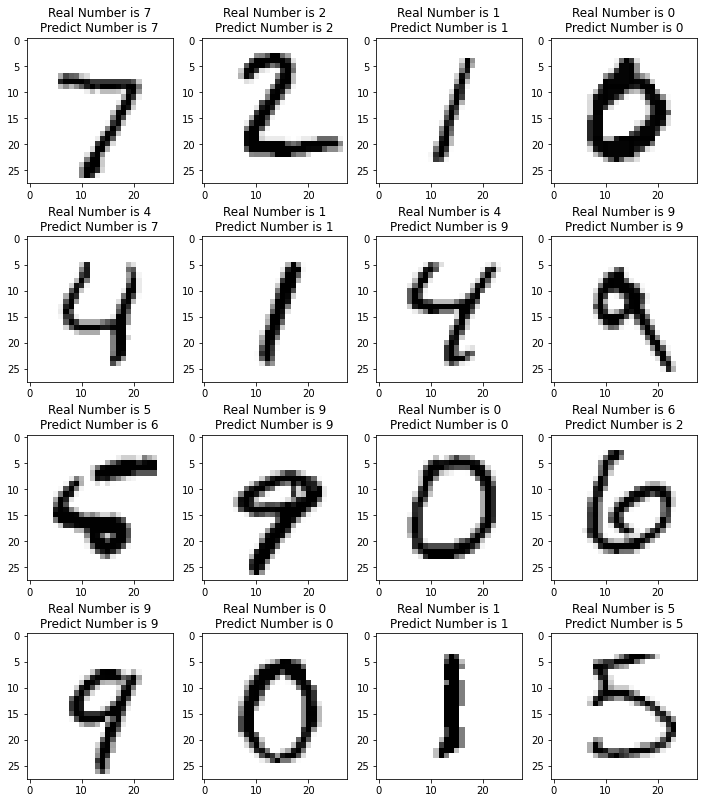

In [30]:
fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test[i], cmap='binary')
    ax.set(title = f"Real Number is {Y_test[i]}\nPredict Number is {Y_pred[i]}");